# Building the TF-TF network edge list
This is the first of three notebooks required to build a TF-TF interaction network compatible with the KG UI. Here, we build an initial edge list of TF-TF interactions by performing ChEA3 transcription factor enrichment analysis (TFEA) on RummaGEO gene sets. 

After finishing this notebook, users should filter the network using `filter_assertions.ipynb`. 
## Set-Up 
First, import required packages. 

In [1]:
import pyenrichr as py
import os
import numpy as np
import pandas as pd
import tqdm
import warnings
from matplotlib import pyplot as plt
from collections import defaultdict

Define the raw data and output directories and create them if they don't already exist: 
1. `raw_data` holds all raw data files. Create one subdirectory for the TFEA libraries, `chea3libs`
2. `edge_constructing_files` will store the output files. 

In [2]:
raw_data = './raw_data'
output = './edge_constructing_files'

if not os.path.exists(raw_data):
    os.mkdir(raw_data)
    os.mkdir(f'{raw_data}/chea3libs')
if not os.path.exists(output):
    os.mkdir(output)

## TFEA using RummaGEO sets
### Downloading required input data
TF enrichment analysis for each of the 171k RummaGEO gene sets is performed using a local version of ChEA3.
This requires files from two locations:
1. RummaGEO:
- Navigate to https://rummageo.com/, then click on downloads. Click on `human-geo-auto.gmt.gz` to download all human gene sets.
- Unzip the file and move it to `raw_data`
2. ChEA3: 
- Navigate to https://maayanlab.cloud/chea3/. Click on 'downloads' in the top right
- Download the following six files (all of the files with file type `primary`) by clicking on their names:
    1. ARCHS4_Coexpression.gmt
    2. ENCODE_ChIP-seq.gmt
    3. Enrichr_Queries.gmt
    4. GTEx_Coexpression.gmt
    5. Literature_ChIP-seq.gmt
    6. ReMap_ChIP-seq.gmt
- Move all six files to `raw_data/chea3libs`
 

### Building the mean ranks matrix
Define two functions: `read_gmt_file`, which uploads a gmt file as a dictionary, and `split_dict`, which divides a large dictionary into N smaller subdictionaries. These are used to process the RummaGEO download file. 

Import the RummaGEO data and split it into subdictionaries.

In [3]:
def read_gmt_file(path, mode):
  """
  reads a GMT file into a dictionary
  this is formatted depending on the gmt being uploaded, specified by 'mode' 
  """
  gmt = {}
  print("Reading {}".format(path))
  with open(path, "r") as file:
    # read a tab-delimited GMT formatted as "term gene1 gene2 ... geneN" and check for set size
    if mode == 'raw':
      for line in tqdm.tqdm(file):
        parts = line.strip().split('\t')
        if len(parts) > 5:
          gmt[parts[0].strip()] = set(parts[1:])

    # read a GMT file formatted as "signature id tf1 tf2 tf3 ... tf10"
    elif mode == 'signed':
      for line in tqdm.tqdm(file):
        signature, id, *tf = line.strip().split()
        gmt[" ".join([signature, id])] = set(tf)

    # similar to mode = 'raw'
    elif mode == 'transpose':
      for line in tqdm.tqdm(file):
        tf, *signature = line.strip().split()
        gmt[tf] = set(signature)
           
  return gmt

def split_dict(original_dict, N):
    """
    divides a dictionary into N subdictionaries
    """
    iter_dict = iter(original_dict.items())
    list_of_dicts = []
    
    while True:
        small_dict = {}
        try:
            for _ in range(N):
                key, value = next(iter_dict)
                small_dict[key] = value
        except StopIteration:
            if small_dict:
                list_of_dicts.append(small_dict)
            break
        list_of_dicts.append(small_dict)
    
    return list_of_dicts

We only consider gene sets that have clear control vs perturbation groups.  We also split the larger list of gene sets into smaller subsets for processing. 


In [4]:
rummageo = f"{raw_data}/human-geo-auto.gmt"
n_subdicts = 1000
geo = read_gmt_file(rummageo, mode='raw')

gsets_to_keep_f = f"{raw_data}/single_perturbation_gses.txt"
gsets_to_keep = []
filtered_gsets = {} 

with open(gsets_to_keep_f, 'r') as file:
    gsets_to_keep = [line.strip() for line in file]

for sig, gene_set in geo.items():
    gse_tag = sig.split("-")[0].strip()
    if gse_tag in gsets_to_keep:
        filtered_gsets[sig] = gene_set

geo_split = split_dict(filtered_gsets, n_subdicts)

Reading ./raw_data/human-geo-auto.gmt


171441it [00:27, 6174.62it/s] 


For each gene set, rank TFs based on enrichment and record the mean rank across ChEA3 libraries.\
**This step can take several hours.**

Save the mean ranks matrix to a CSV file.

In [5]:
def mean_rank(results):
    """
    determines the mean rank of a TF across all ChEA3 libraries
    """
    if results:
        # extract gene set names from the first result
        sigs = list(results[next(iter(results))].columns)

    # extract unique transcription factor (tf) names from all indices
    tfs = list(set(tf for result in results.values() for tf in result.index))

    # initialize arrays for scores and counts
    tf_scores = np.zeros((len(tfs), len(sigs)))
    tf_counts = np.zeros((len(tfs), len(sigs)))

    # create a mapping from transcription factor names to indices
    tf_index_map = {t: idx for idx, t in enumerate(tfs)}

    # aggregate scores and counts
    for l, result in results.items():
        for t in result.index:
            temp = result.loc[t]
            idx = tf_index_map[t]
            if len(temp.shape) == 1:
                tf_scores[idx, :] += temp.values
                tf_counts[idx, :] += 1
            else:
                for ii in range(temp.shape[0]):
                    tf_scores[idx, :] += temp.iloc[ii, :].values
                    tf_counts[idx, :] += 1

    # calculate the mean scores by dividing tf_scores by tf_counts element-wise
    mean_scores = pd.DataFrame(np.round(np.divide(tf_scores, tf_counts, out=np.zeros_like(tf_scores), 
                                                  where=tf_counts != 0)), index=tfs, columns=sigs)

    return mean_scores


In [6]:
warnings.simplefilter("ignore")

fisher = py.enrichment.FastFisher(34000)

# pre-read the GMT files and store the results in a dictionary
libraries = {}
for lib in os.listdir(f"{raw_data}/chea3libs"):
    libraries[lib] = read_gmt_file(f"{raw_data}/chea3libs/{lib}", mode='raw')

# process each item in geo_split
mranks = []

for i in tqdm.tqdm(range(len(geo_split))):
    results = {}
    for lib_name, lib_gmt in libraries.items():
        # use the pre-read library data
        res = py.enrichment.fisher(geo_split[i], lib_gmt, min_set_size=10, verbose=False, fisher=fisher)
        temp = py.enrichment.consolidate(res).rank(axis=0)
        temp.index = [x.split("_")[0] for x in temp.index]
        results[lib_name] = temp
    
    mr = mean_rank(results)
    mranks.append(mr)

Reading ./raw_data/chea3libs/ARCHS4_Coexpression.gmt


1628it [00:00, 26936.31it/s]


Reading ./raw_data/chea3libs/ReMap_ChIP-seq.gmt


297it [00:00, 6396.32it/s]


Reading ./raw_data/chea3libs/Enrichr_Queries.gmt


1404it [00:00, 9481.17it/s]


Reading ./raw_data/chea3libs/GTEx_Coexpression.gmt


1607it [00:00, 22728.95it/s]


Reading ./raw_data/chea3libs/ENCODE_ChIP-seq.gmt


552it [00:00, 6571.64it/s]


Reading ./raw_data/chea3libs/Literature_ChIP-seq.gmt


307it [00:00, 3163.02it/s]
100%|██████████| 30/30 [38:19<00:00, 76.66s/it]


Save the output to a file. This ensures that the mean ranks matrix need only be generated once. 

In [7]:
mranks = pd.concat(mranks, axis=1)
mranks.to_csv(f"{output}/mean_ranks_matrix.csv")

### Preliminary pruning
Working from the mean ranks matrix, remove all but the **top 10** most highly ranked TFs for each signature. These are the ten most likely TFs to be regulators of the genes in their respective signatures


In [8]:
def preprocess(path):
  """
  uploads a TF rank matrix
  """
  matrix = pd.read_csv(path)
  matrix.index = matrix.iloc[:, 0]
  matrix = matrix.drop(columns = matrix.columns[0])
  matrix = matrix.astype(np.int64)
  return matrix


def filter_by_rank(matrix, rank_method = "min", threshold = 15):
  """
  produces a library of signatures and the most highly enriched TFs (rank <= 10)
  """
  MAX_RANK = 10 

  results = {Signature : None for Signature in matrix.columns}

  for Signature in matrix.columns:
    rank_index = matrix[Signature].rank(method = rank_method).astype(int)
    rank_top_tfs = [rank <= MAX_RANK for rank in rank_index]

    # Remove outliers above specified threshold
    if len(matrix.index[rank_top_tfs]) <= threshold:
      results[Signature] = matrix.index[rank_top_tfs].to_list()
    else:
      del results[Signature]
  
  # returns a matrix of gene set names x top 10 transcription factors (basically transposed GMT)
  return results


Filter the TFs by rank. 

In [9]:
mean_ranks_matrix = preprocess(f"{output}/mean_ranks_matrix.csv")
high_rank_matrix = filter_by_rank(mean_ranks_matrix)

Save output as `.gmt` file

In [10]:
def write_gmt(path, library, transpose=False):
  """
  writes a GMT to a file
  """
  with open(path, "w") as file:
    for term, items in tqdm.tqdm(library.items()):
      file.write(f"{term}\t\t")
      for item in items:
        if transpose:
          signature_join = "-".join(item.split())
          file.write(f"{signature_join}\t")
        else:
          file.write(f"{item}\t")
      file.write("\n")

In [11]:
write_gmt(f"{output}/filtered_tfsets.gmt", high_rank_matrix)

100%|██████████| 29328/29328 [00:00<00:00, 728394.58it/s]


## Creating the TF-TF edge list 
### Count the number of times each TF-TF interaction occurs.
* Create the transpose of the GMT, where each line is a TF followed by the gene sets in which it is ranked (`transpose_human.gmt`)
* For a given highly ranked TF, find all sets where it is present. Mark a source-target edge with any TFs present in the same set.
* The **directionality** of the edge is determined by the sign (up/down) of the gene set where the relationship occurs. 

Create the transpose matrix of a GMT.

In [12]:
def gmt_transpose(library):
  """
  creates the transpose of a GMT file
  """
  tfs = list(set([tf for sublist in library.values() for tf in sublist]))
  transpose = {}
  for tf in tqdm.tqdm(tfs):
    collect = []
    for signature in library:
      if tf in library[signature]:
        collect.append(signature)
    transpose[tf] = set(collect)
  return dict(transpose)


In [13]:
# create the transpose and save to a file
tf_sets = read_gmt_file(f"{output}/filtered_tfsets.gmt", mode='signed')
tf_transpose = gmt_transpose(tf_sets)
write_gmt(f"{output}/tf_transpose.gmt", tf_transpose, transpose=True)

Reading ./edge_constructing_files/filtered_tfsets.gmt


29328it [00:00, 179686.30it/s]
100%|██████████| 1588/1588 [00:00<00:00, 25379.15it/s]


Create a nested dictionary to store the edge counts. Count the number of times each edge is observed.\
Dimensions: source_tf --> target_tf --> direction (up/down)

In [14]:
# upload the RummaGEO sets once again
geo_gmt = read_gmt_file("raw_data/human-geo-auto.gmt", mode='raw')

high_rank_tfs = list(tf_transpose.keys())

# create dictionary to store edge counts
edge_matrix = {source : {target : {
  "+": 0,
  "-": 0
} for target in high_rank_tfs} for source in high_rank_tfs}

# calculate edge counts
for source in tqdm.tqdm(high_rank_tfs):
  for signature in tf_transpose[source]:

    spl = signature.rsplit(" ", 1)
    dir = "+" if spl[1] == "up" else "-" # "dn"
    joined_sig = " ".join(spl)

    # if the gene set name is in the keys for the rummaGEO GMT
    if joined_sig in geo_gmt.keys():
      
      # for each TF in the list of all TFs
      for target in high_rank_tfs:
        if target in geo_gmt[joined_sig]: # TF is in list of DEGs
          edge_matrix[source][target][dir] += 1
   
    else:
      raise Exception("Signature {} not found".format(joined_sig))

Reading raw_data/human-geo-auto.gmt


171441it [01:19, 2144.66it/s] 
100%|██████████| 1588/1588 [00:30<00:00, 51.32it/s] 


In [19]:
# flatten the results into DataFrame and remove edges with <= 0
s = edge_matrix.keys()
t = {target for targets in edge_matrix.values() for target in targets.keys()}
targets = list(t)

hindex = pd.MultiIndex.from_product([s, t, ["+", "-"]],
  names = ["source", "target", "direction"])

filtered_mat = []

for source, targets in tqdm.tqdm(edge_matrix.items()):
  for target, data in targets.items():
    for direction, count in data.items():
      if count >= 10:
        filtered_mat.append((source, target, direction, count))

df = pd.DataFrame(filtered_mat, columns =['source', 'target', 'direction', 'count'])


print(f"Number of edges counted: {df['count'].sum()}")
print(f"Number of unique edges: {len(df['count'])}")
print(f"Number of unique sources: {len(df['source'].value_counts())}")
print(f"Number of unique targets: {len(set(df['target']))}")

100%|██████████| 1588/1588 [00:00<00:00, 3375.89it/s]


Number of edges counted: 10381518
Number of unique edges: 372382
Number of unique sources: 728
Number of unique targets: 1545


In [20]:
# save results to a csv
df.set_index(['source', 'target', 'direction'], inplace=True)
df.to_csv(f"{output}/edge_list_unfiltered.csv")

## Calculate network statistics and plot connectivity distributions
1. Generates basic network statistics for the input network
2. Generates log-scale histograms of the relative frequency distributions for in-degree and out-degree

                                                     0
Total nodes                                1556.000000
Unique source nodes                         728.000000
Unique target nodes                        1545.000000
Total edges                              372382.000000
Number of up edges                       183826.000000
Number of dn edges                       188556.000000
Avg out links per node                      241.023948
Avg in links per node                       511.513736
Avg total links per node                    239.320051
Number of self loops                       1022.000000
Number of upregulation feedback loops     14150.000000
Number of downregulation feedback loops   13057.000000


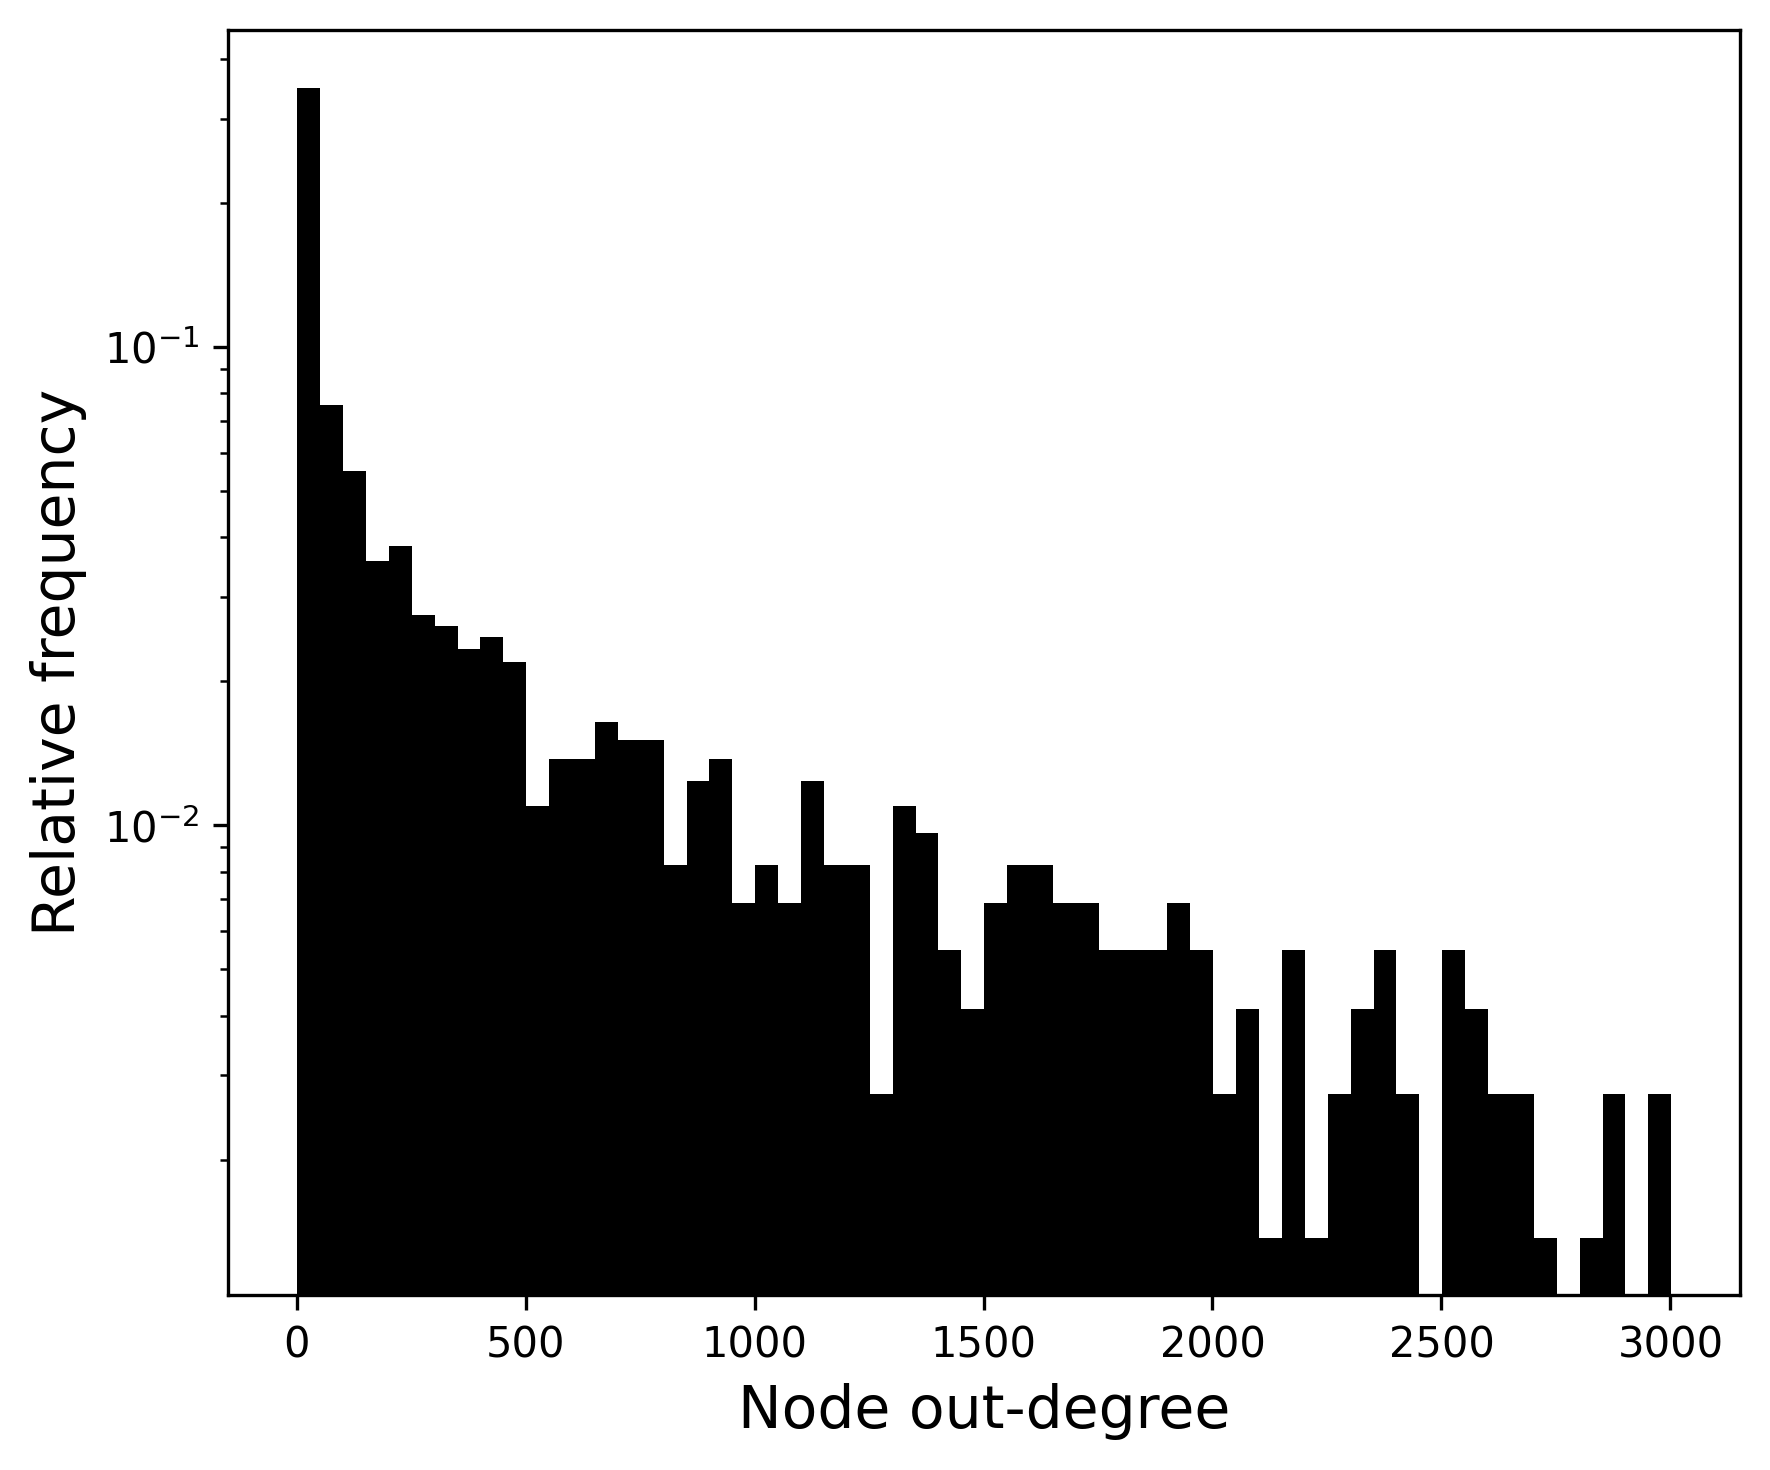

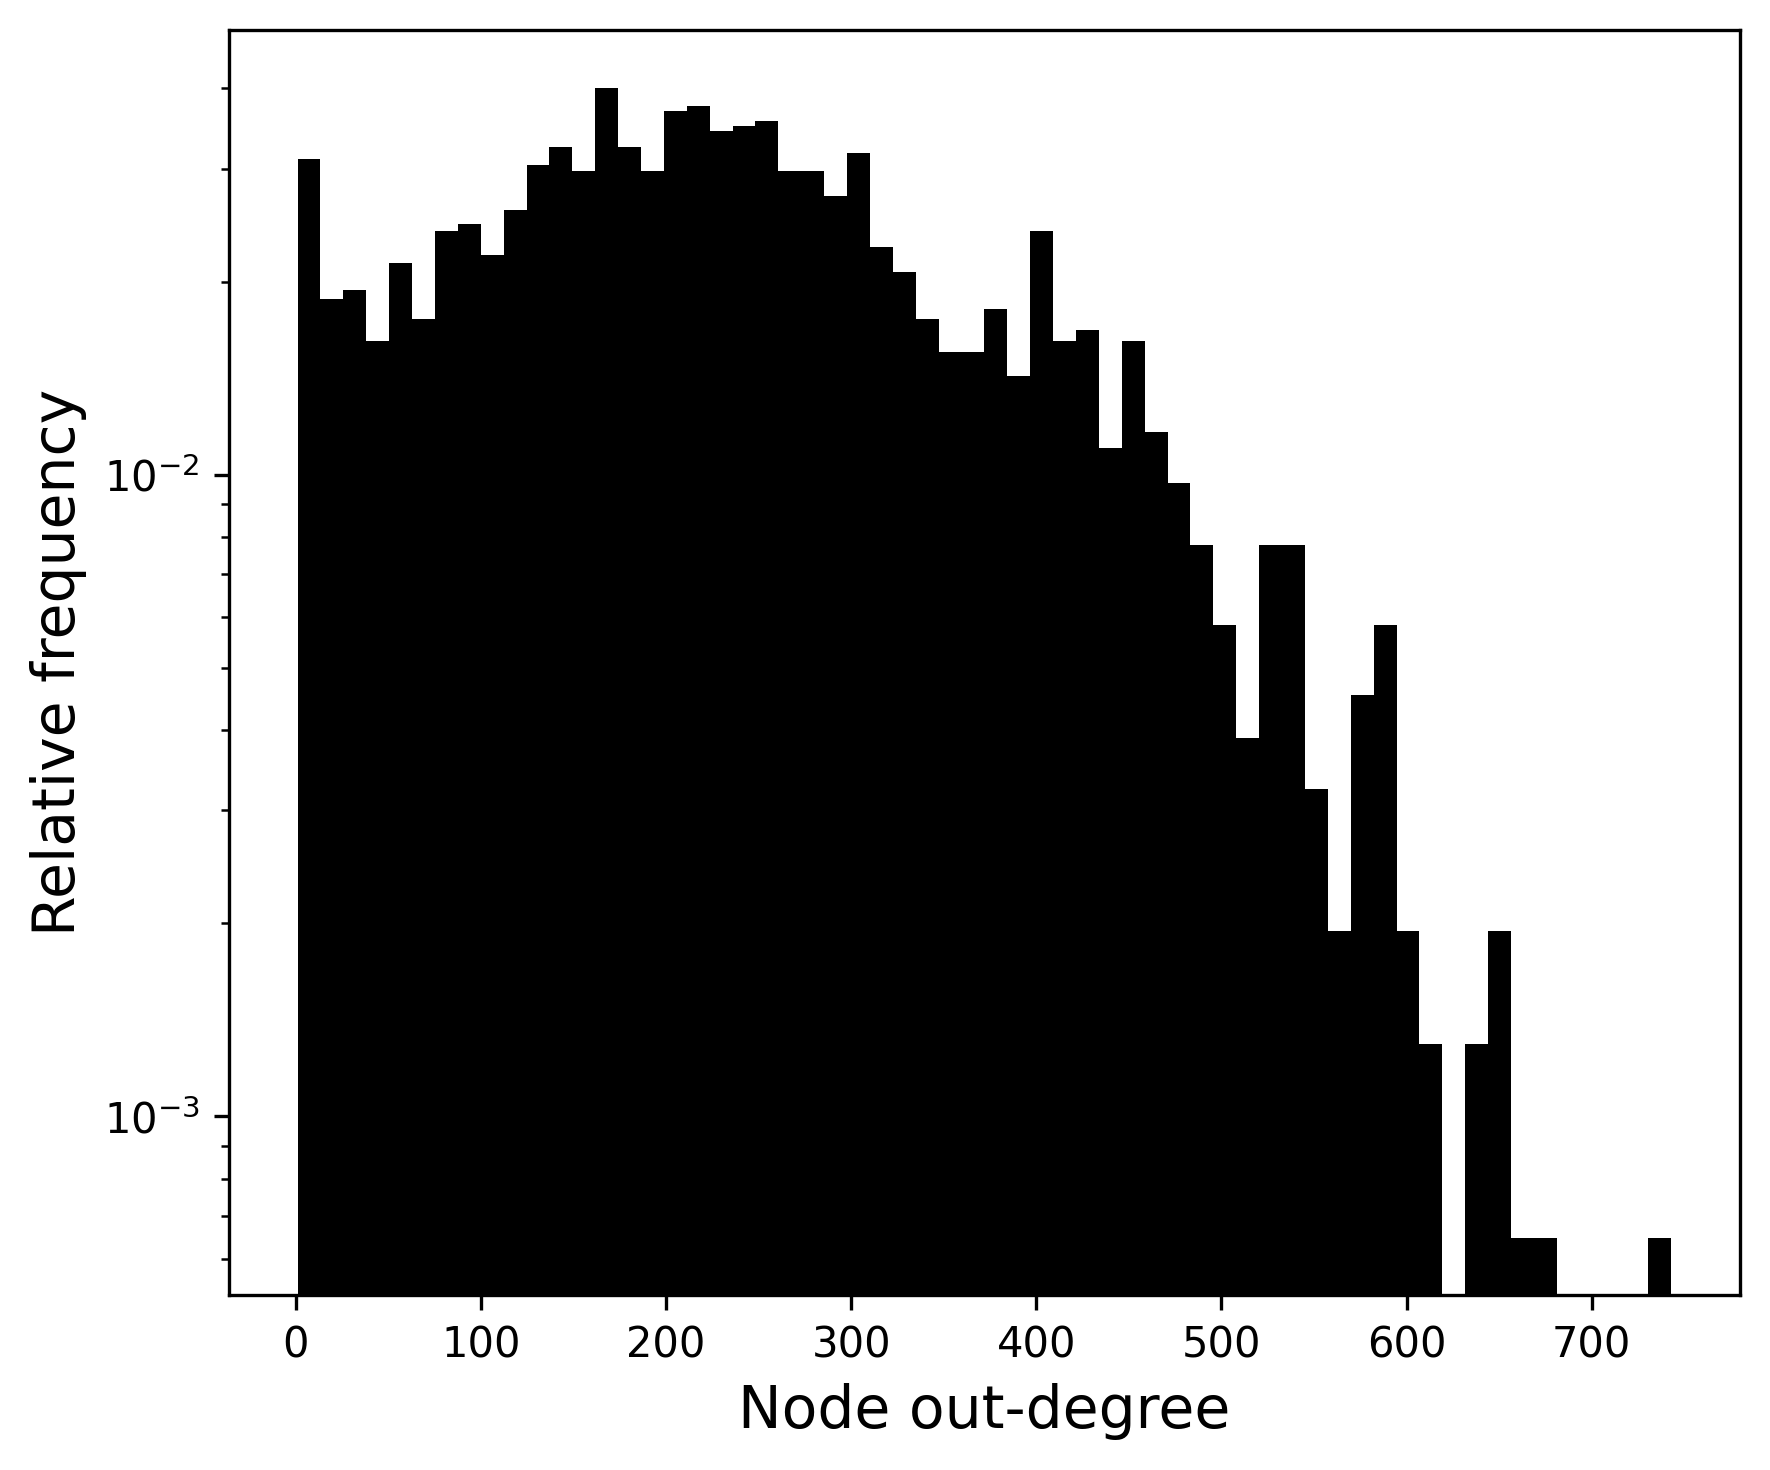

In [44]:
import network_statistics as nstats

edge_file = f"{output}/edge_list_unfiltered.csv"
nstats.all_network_stats(edge_file)
nstats.plot_connectivity_distrib(edge_file, output)